In [29]:
import numpy as np

from qiskit import QuantumCircuit

In [30]:
# TODO: Cleanup and move upward

from qiskit import execute
from qiskit.providers.fake_provider import FakeManilaV2
from qiskit import transpile
from qiskit.compiler import transpile
from qiskit.tools.monitor import job_monitor
import matplotlib.pyplot as plt
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.quantum_info import *
from qiskit.circuit.library import HGate, RXGate

In [31]:
# TODO: Rename all lambdas to lambda_ to avoid conflict with Python keyword
#       Alternatively use letter h
#       Turn lambda (also n?) into ndarrays

n = 4
lambd = 1.2

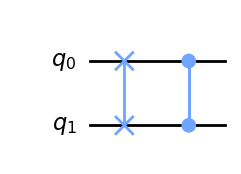

In [32]:
fswap_qc = QuantumCircuit(2)
fswap_qc.swap(0, 1)
fswap_qc.cz(0, 1)

FSwapGate = fswap_qc.to_gate()

fswap_qc.draw(output="mpl")

In [33]:
# TODO: Is theta a good name? Find out if this angle is called anything in particular

def theta(n: int, k: int, lambda_: float) -> float:
    theta = 2 * np.pi * k / n
    x = np.cos(theta)
    y = np.sin(theta)

    return np.arccos((lambda_ - x) / np.sqrt((lambda_ - x) ** 2 + y**2))

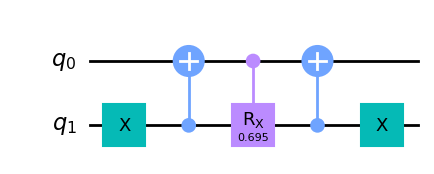

In [34]:
# TODO: Name better
#       Make parameterized gate?

qc = QuantumCircuit(2)
qc.x(1)
qc.cx(1, 0)
qc.crx(theta(n, 1, lambd), 0, 1)  # TODO: k hardcoded to 1. NOT GENERAL, NEED FUNCTION
qc.cx(1, 0)
qc.x(1)

BogoliubovGate = qc.to_instruction()

qc.draw(output="mpl")

In [35]:
def thetak(k, lamb):
    num = lamb - np.cos(2 * np.pi * k / n)
    denom = np.sqrt(
        (lamb - np.cos(2 * np.pi * k / n)) ** 2 + np.sin(2 * np.pi * k / n) ** 2
    )
    theta = np.arccos(num / denom)
    return theta


# Create functions based on the decomposition included in appendix of Ising paper
def bog(qcirc, qubits, theta):
    qcirc.x(qubits[1])
    qcirc.cx(qubits[1], qubits[0])
    qcirc.append(RXGate(theta=theta).control(), qubits)
    qcirc.cx(qubits[1], qubits[0])
    qcirc.x(qubits[1])
    qcirc.barrier()


def fourier(qcirc, qubits, phase):
    qcirc.rz(phase, qubits[0])
    qcirc.cx(qubits[0], qubits[1])
    qcirc.append(HGate().control(), reversed(qubits))
    qcirc.cx(qubits[0], qubits[1])
    qcirc.cz(qubits[0], qubits[1])
    qcirc.barrier()


def fermionicSwap(circuit, qubits):
    circuit.swap(qubits[0], qubits[1])
    circuit.cz(qubits[0], qubits[1])


def digit_sum(n):
    num_str = str(n)
    sum = 0
    for i in range(0, len(num_str)):
        sum += int(num_str[i])
    return sum


def applyDisentaglementGates(qcirc, lamb):
    bog(qcirc, qcirc.qubits[0:2], thetak(1.0, lamb))
    fourier(qcirc, qcirc.qubits[0:2], 2 * np.pi / n)
    fourier(qcirc, qcirc.qubits[2:4], 0.0)
    # fermionicSwap(qc, qc.qubits[1:3])
    fourier(qcirc, qcirc.qubits[0:2], 0.0)
    fourier(qcirc, qcirc.qubits[2:4], 0.0)
    # fermionicSwap(qc, qc.qubits[1:3])


def executeJobAndGetMagnetization(qcirc, backend, shots, max_credits):
    # magnetization
    mag = []
    job = execute(qcirc, backend=backend, shots=shots, max_credits=max_credits)
    job_monitor(job)
    result = job.result()
    counts = result.get_counts(qcirc)
    ##while not '0000' in counts:
    #    job = execute(qc, backend=backend, shots=shots, max_credits=max_credits)
    #    job_monitor(job)
    #    result = job.result()
    #    counts = result.get_counts(qc)
    # Check what ground state is based on lambda

    r1 = list(counts.keys())
    r2 = list(counts.values())
    M = 0
    for j in range(0, len(r1)):
        M = M + (4 - 2 * digit_sum(r1[j])) * r2[j] / shots
    # print("$\lambda$: ",lam,", $<\sigma_{z}>$: ",M/4)
    mag.append(M / 4)
    return mag


def ground_state(lamb, backend_name):  # backend is now an imput, so we can plot
    # different ones easily - Bruna
    # Create a quantum Circuit with 4 quantum bits and 4 classical
    qcirc = QuantumCircuit(4, 4)
    # Set correct ground state if lambda < 1
    if lamb < 1:
        qcirc.x(3)
        qcirc.barrier()

    applyDisentaglementGates(qcirc, lamb)
    # Set measurement step
    for i in range(0, 4):
        qcirc.measure(i, i)

    return executeJobAndGetMagnetization(qcirc, FakeManilaV2(), 1024, 10)


print(ground_state(lambd, "qasm_simulator"))
# print(ground_state(.8,'statevector_simulator'))

Job Status: job has successfully run
[0.8857421875]


In [36]:
lmbd = np.arange(0, 1.75, 0.1)
sigmaz = []
for l in lmbd:
    sigmaz.append(ground_state(l, "qasm_simulator"))

print(sigmaz)

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
[[0.0029296875], [0.048828125], [0.1142578125], [0.14453125], [0.171875], [0.212890625], [0.255859375], [0.314453125], [0.302734375], [0.34765625], [0.849609375], [0.8671875], [0.896484375], [0.8974609375], [0.912109375], [0.9287109375], [0.927734375], [0.931640625]]


(0.0, 1.8)

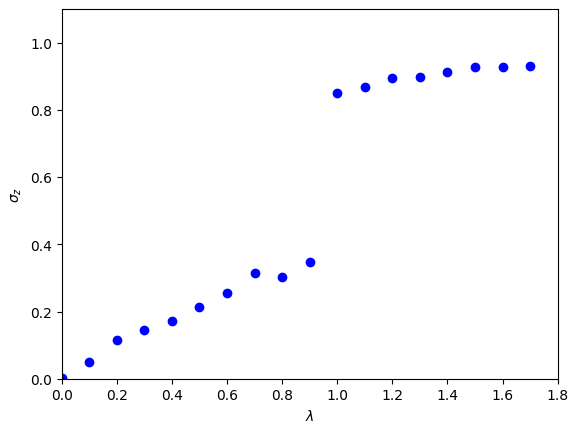

In [37]:
plt.plot(lmbd, sigmaz, "bo")
plt.ylabel("$\\sigma_z$")
plt.xlabel("$\\lambda$")
plt.ylim(0.0, 1.1)
plt.xlim(0.0, 1.8)

Job Status: job has successfully run


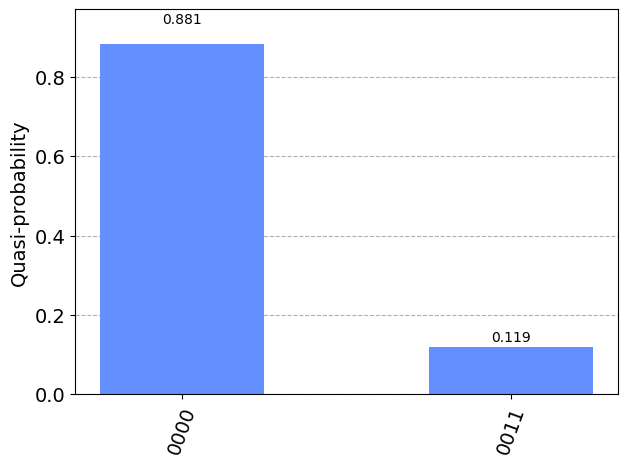

In [38]:
# Start up and initialize circuit
# Measurement
qcirc = QuantumCircuit(4, 4)
# Set correct ground state if lambda < 1
if lambd < 1:
    qcirc.x(3)
    qcirc.barrier()

    # Apply disentangling gates
applyDisentaglementGates(qcirc, lambd)
# Set measurement step
for i in range(0, 4):
    qcirc.measure(i, i)


# Using a fake backend provided with qiskit

backend = FakeManilaV2()
# Transipling essentially converts the circuit into a something that can run on the specific hardware specified
transpiled_circuit = transpile(qcirc, backend)
job = backend.run(transpiled_circuit)
counts = job.result().get_counts()

shots = 1024
max_credits = 10  # Max number of credits to spend on execution
job = execute(qcirc, backend=backend, shots=shots, max_credits=max_credits)
job_monitor(job)
result = job.result()
counts = result.get_counts(qcirc)

plot_distribution(counts)

# had to comment this part because qc is a local variable in groundstate function now - Bruna

In [39]:
phi = np.arccos(lambd / np.sqrt(1 + lambd**2)) / 2
# print(result.get_statevector(qc))
print("|0000> probability should be: ", np.cos(phi) ** 2)
print("|0011> probability should be: ", np.sin(phi) ** 2)

|0000> probability should be:  0.8841106397986879
|0011> probability should be:  0.11588936020131207


In [40]:
def Time_Evo(t, lamb, backend_name):
    quc = QuantumCircuit(4, 4)

    # step 1. we are already in the |111> state

    # time evolution of computational basis, step 2
    quc.u(
        np.arccos(lamb / np.sqrt(1 + lamb**2)),
        np.pi / 2 + 4 * t * np.sqrt(1 + lamb**2),
        0,
        0,
    )
    quc.cx(0, 1)

    # magnetization
    mag = []
    # step 3
    # Apply disentangling gates
    applyDisentaglementGates(quc, lamb)
    # Set measurement step
    for i in range(0, 4):
        quc.measure(i, i)

    # provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
    backend = FakeManilaV2()
    # backend = Aer.get_backend('statevector_simulator')
    # backend = Aer.get_backend('qasm_simulator')
    # backend = provider.get_backend('ibmq_qasm_simulator')
    # backend = provider.get_backend('ibmqx4')
    # backend = provider.get_backend('ibmqx2')
    # backend = provider.get_backend('ibmq_16_melbourne')
    return executeJobAndGetMagnetization(
        quc, backend=FakeManilaV2(), shots=1024, max_credits=10
    )


# f = Time_Evo(qc,1,lambd,'qasm_simulator')
# print(f)

#
ti = 0
tf = 2
time = np.arange(ti, tf, (tf - ti) / 10)
f = []
for t in time:
    f.append(Time_Evo(t, 0.5, "ibmq_athens"))

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


c:\Users\davis\OneDrive - Colorado School of Mines\1 Fall 2023\PHGN 519 Fundamentals of Quantum Information\project-1\ising-model\.venv\Lib\site-packages\qiskit\providers\fake_provider\fake_backend.py:354: RuntimeWarning: Aer not found using BasicAer and no noise
  warnings.warn("Aer not found using BasicAer and no noise", RuntimeWarning)
c:\Users\davis\OneDrive - Colorado School of Mines\1 Fall 2023\PHGN 519 Fundamentals of Quantum Information\project-1\ising-model\.venv\Lib\site-packages\qiskit\utils\deprecation.py:182: UserWarning: Option max_credits is not used by this backend
  return func(*args, **kwargs)


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


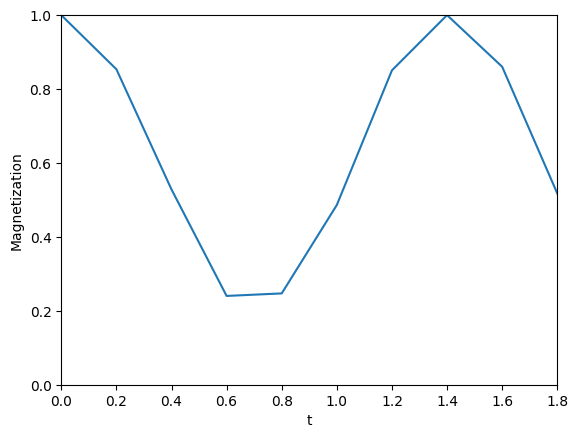

In [41]:
# step 4
plt.plot(time, f)
plt.ylim(0.0, 1)
plt.xlim(0.0, 1.8)
plt.ylabel("Magnetization")
plt.xlabel("t")
plt.show()